![Logo](./Pictures/Logo/CARDIA-PPG_Name_Small.svg)

# Code

## Import

### Processing Libraries

In [1]:
from alive_progress import alive_bar 
from datetime import datetime
import csv
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import platform
import pprint
import re
import scipy
import sys
import time
import traceback

### RPi Specific Libraries

In [2]:
if platform.machine() == 'aarch64':
    from max30102 import MAX30102

### packages config

In [3]:
# matplot magic import for interactive graphs
%matplotlib ipympl
plt.rcParams['figure.figsize'] = (12, 7.5)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.max_open_warning'] = 0

_ = np.seterr(all = 'ignore')

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import clear_output
InteractiveShell.ast_node_interactivity = 'all'

## Costants

In [4]:
# Chebyshev II filter costants
FILTER_N = 4        # order
FILTER_RS = 20      # min attenuation in stop band, dB
FILTER_LF = 0.25    # lower freq of the pass-band, Hz 0.75
FILTER_HF = 10      # upper freq of the pass-band, Hz 10

# Find Peaks Distance (seconds)
FIND_PEAKS_DISTANCE = 0.6

MEASURE_DURATION = 30

PLT_FIGSIZE = PLT_FIGSIZE_O = (12, 5)

## Functions

In [5]:
# VASCOVID signal import
def import_txt(filename = 'Data/ppg-vascovid-fabrice.txt'):
    with open(filename) as f:
        return np.array([int(l) for l in f.read().splitlines()])
    
def check_measure(ppg, subject):
    if (len(ppg.pulses) < 5):
        print('Incorrect measure: Low number of utilizable pulses', file = sys.stderr)
        return False
    elif (ppg.RI > 100) or (np.abs(ppg.SI-8.17) > 5):
        print('Incorrect measure: Improbable values', file = sys.stderr)
        return False
    elif (np.std(ppg.indices['SDPTG_AI']) > 0.1) or (np.std(ppg.RI) > 3) or (np.std(ppg.SI) > 0.01):
        print('Incorrect measure: Standard deviations too big', file = sys.stderr)
        return False
    else:
        print('Correct measure')
        return True
    
def check_health_status(ppg, subject):
    if (ppg.VA <= subject.age+2) and (np.abs(ppg.RI-73) <= 12) and (np.abs(ppg.SI-8.17) <= 2.17):
        print('Healthy subject')
        subject.risk = False
        return True
    else:
        # ☠️
        print('Unhealthy subject', file = sys.stderr)
        subject.risk = True
        return False

def ask_user_info():
    confirm = False
    c = 0
    while not confirm:
        if c:
            clear_output(wait = False)
        subject_name   =       input('Name:        ')
        subject_heigth = float(input('Heigth [m]:  '))
        subject_age    = float(input('Age:         '))
        confirm = input('Confirm? (y/n): ').lower().strip() == 'y'
        c = 1
    return SUBJECT(name = subject_name, heigth = subject_heigth, age = subject_age)

def save_measurement(ppg, subject):
    filename = ('ppg-' +
                subject.name.replace(' ', '-').lower() +
                '-' +
                str(int(100*float(subject.heigth))) +
                '-' +
                ppg.date.replace(' ', '-') +
                '.pickle')
    with open('Data/Measurements/' + filename, 'wb') as f:
        pickle.dump((ppg, subject), f)

In [6]:
def measure(sensor):
    signal = np.empty(0)
    t_start = now = time.monotonic()  # Starting time of the acquisition (second)
    
    with alive_bar(title='Measuring', force_tty = True, unknown = 'wait') as bar:
        while (now - t_start < MEASURE_DURATION):
            now = time.monotonic()
            # The check() method has to be continuously polled, to check if
            # there are new readings into the sensor's FIFO queue. When new
            # readings are available, this function will put them into the storage.
            sensor.check()

            # Check if the storage contains available samples
            if sensor.available():
                # Access the storage FIFO and gather the readings (integers)
                red_reading = sensor.pop_red_from_storage()
                # ir_reading = sensor.pop_ir_from_storage()
                # print(red_reading)

                signal = np.append(signal, red_reading)
                bar()

    t_end = time.monotonic()
    duration = t_end - t_start
    fs = np.size(signal)/duration
    return signal, fs

## Class

In [7]:
class PPG:
    def __init__(self,
                 signal,                       # np array: https://numpy.org/doc/stable/reference/arrays.ndarray.html
                 fs = 100,                     # default sampling freq of our ppg sensor
                 subject = None,               # subject id or name
                 info = '',                    # signal info, eg our vs vascovid
                 date = None,                  # measurment datetime
                 flipped = False,              # set to True to skip flipping
                 # outliers_rejected = False,    # set to True to skip reject_outliers_mad()
                 outliers_filled = False,      # set to True to skip fill_outliers_mad()
                 filtered = False,             # set to True to skip filter_cheb2()
                 silent = False,               # set to True to suppress output
                ):
        self.signal = signal
        self.fs = fs
        self.info = info
        self.date = date
        
        self.subject = subject.name
        self.heigth = subject.heigth

        self.flipped = flipped
        if self.flipped == False:
            self.flip()
        
        # It's better to substitute the outliers
        # self.outliers_rejected = outliers_rejected
        # if self.outliers_rejected == False:
        #     self.reject_outliers_mad()
            
        self.outliers_filled = outliers_filled
        if self.outliers_filled == False:
            self.fill_outliers_mad()
            
        # Compute after the number of samples has been modified
        self.mean_length_duration()
        
        # Save the non filtered signal before filtering it
        self.signal_unfilt = self.signal
        self.filtered = filtered
        if self.filtered == False:
            self.filter_cheb2_bandpass()
        
        # Compute the time coordinates of the positions of pulses start
        # and store them in self.peaks
        self.find_peaks()
        
        # Separate pulses
        self.separate_pulses()
        
        # Reject pulses
        self.reject_pulses()
        
        # Build indices arrays
        self.build_indices_arrays()
        
        # Remove pulses with outlier indices
        self.remove_indeces_outliers()
        
        self.SI = self.heigth/np.mean(self.indices['dt'])
        self.RI = np.mean(self.indices['RI'])
        self.SDPTG_AI = np.mean(self.indices['SDPTG_AI'])
        self.VA = (self.SDPTG_AI + 1.515)/0.023
        self.BPM = np.size(self.pulses_unfilt)*60/self.duration
        
        if not silent:
            # print(f'Mean:  {self.mean:.0f}')
            # print(f'Std:   {self.std:.1f}')
            self.print_indices_data()
            self.print_discarded_pulses()
            print('\n')
            check_measure(ppg = self, subject = subject)
            check_health_status(ppg = self, subject = subject)
            self.plot('signal')
            self.plot('pulses')
            self.plot('peaks')
            # Histogram
            # self.plot('indices')
        
    # Functions
    def mean_length_duration(self):
        # Used when class is initialized and whenever the number of measurements
        # is modified
        self.mean = self.signal.mean()
        self.std = np.std(self.signal)
        self.length = self.signal.size
        self.duration = self.length/self.fs
        self.t = np.arange(self.length)/self.fs
            
    def flip(self):
        self.signal = 2*round(self.signal.mean()) - self.signal
        self.flipped = True
        
    # Better to use fill_outliers_mad()
    def reject_outliers_mad(self):
        self.signal = self.signal[abs(self.signal - np.median(self.signal)) 
                                  < 3*-1/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.signal)]
        self.outliers_rejected = True
        
    def fill_outliers_mad(self):
        self.outliers_indices  = np.where(abs(self.signal - np.median(self.signal)) >= 3*-1/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.signal))[0]
        # print(f'self.outliers_indices: {self.outliers_indices}', file = sys.stderr)
        for outlier in self.outliers_indices:
            out_act = self.signal[outlier]
            if outlier == 0:
                # First one, no previous one exists
                out_prev = self.signal[outlier + 2]
            else:
                out_prev = self.signal[outlier - 1]
            if outlier == self.signal.size - 1:
                # Last one, no next one exists
                out_next = self.signal[outlier - 2]
            else:
                out_next = self.signal[outlier + 1]
            # Replace the outlier w/ the mean of the two adjacent
            self.signal[outlier] = round(np.mean([out_next, out_prev]))
        self.outliers_filled = True
    
    def filter_cheb2_bandpass(self):
        self.filter_bandpass = scipy.signal.cheby2(
                          N = FILTER_N,                   # order
                          rs = FILTER_RS,                 # min attenuation in stop band, dB
                          Wn = [FILTER_LF, FILTER_HF],    # passband frequencies
                          btype = 'bandpass',             # type of filter
                          fs = self.fs,                   # sampling frequency
                          output = 'sos',                 # second-order sections
                          analog = False,                 # digital filter
                         )
        self.signal = scipy.signal.sosfiltfilt(self.filter_bandpass, self.signal)
        
    # Not used
    def filter_cheb2_lowpass(self):
        self.filter_lowpass = scipy.signal.cheby2(
                          N = FILTER_N,                   # order
                          rs = FILTER_RS,                 # min attenuation in stop band, dB
                          Wn = 3,
                          btype = 'low',                  # type of filter
                          fs = self.fs,                   # sampling frequency
                          output = 'sos',                 # second-order sections
                          analog = False,                 # digital filter
                         )
        self.signal_lowpass = scipy.signal.sosfiltfilt(self.filter_lowpass, self.signal)
        # self.signal = self.signal_lowpass
        
    def find_peaks(self):
        # Find the startin point of the pulses
        self.peaks, _ = scipy.signal.find_peaks(-1*self.signal, distance = FIND_PEAKS_DISTANCE*self.fs)
    
    def separate_pulses(self):
        self.pulses = np.empty(0)
        for i, p in enumerate(self.peaks[:-1]):
            p_start = p
            p_end = self.peaks[i + 1] - 1
            # print(f'    p_start: {p_start}, p_end: {p_end}', file = sys.stderr)
            try:
                pulse = PULSE(
                    signal = self.signal[p_start:p_end],
                    start = p_start,
                    heigth = self.heigth,
                    fs = self.fs,
                )
                self.pulses = np.append(self.pulses, pulse)
            except Exception as e:
                print(f'Failed to create pulse {i}: {e}', file = sys.stderr)
                # print(f'    p_start: {p_start}, p_end: {p_end}', file = sys.stderr)
                # print(f'    t_start: {p_start/self.fs}, t_end: {p_end/self.fs}', file = sys.stderr)
                # Print full error stack
                # traceback.print_exc()
    
    def reject_pulses(self):
        self.pulses_unfilt = self.pulses
        self.discarded_pulses = {}
       
        # Trash pulse with pulse.trash == True
        paperino = np.size(self.pulses)
        self.pulses = [p for p in self.pulses if not p.trash]
        self.discarded_pulses['trashed'] = paperino - np.size(self.pulses)
        
        # Filtering using pulse lenght and dt resulted unreliable
        
        # # Filter outliers pulses by their total length:
        # pippo = np.size(self.pulses)
        # pulses_len = [pulse.length for pulse in self.pulses]
        # # self.pulses = [p for p in self.pulses if (
        # #     np.abs(p.length - np.median(pulses_len)) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(pulses_len))]
        # self.pulses = [p for p in self.pulses if (
        #      np.abs(p.length - np.mean(pulses_len)) < 1*np.std(pulses_len))]              
        # self.discarded_pulses['length'] = pippo - np.size(self.pulses)
        
        # # Filter pulses that have a too small dt:
        # pluto = np.size(self.pulses)
        # dt = np.array([pulse.dt for pulse in self.pulses])
        # # self.pulses = [p for p in self.pulses if (
        # #     np.abs(p.dt - np.median(dt)) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(dt))]
        # self.pulses = [p for p in self.pulses if (
        #     np.abs(p.dt - np.mean(dt)) < 1*np.std(dt))]
        # self.discarded_pulses['dt'] = pluto - np.size(self.pulses)
    
    def build_indices_arrays(self):
        self.indices = {}
        self.indices['SDPTG_AI'] = np.array([p.SDPTG_AI for p in self.pulses])
        self.indices['RI'] = np.array([p.RI for p in self.pulses])
        self.indices['dt'] = np.array([p.dt for p in self.pulses])
        
    def print_indices_data(self):
        # print(f'VA:    {self.VA:.1f}')
        # print(f'SI:    {self.SI:.3f}')
        # for i in self.indices:
        #     print(f'{i}:   {np.mean(self.indices[i]):.3f}, std: {i}:    {np.std(self.indices[i]):.3f}')
            
        indices = []
        indices.append({
                  'Index': 'VA',
                  'Mean': float(f'{self.VA:.1f}'),
                  'STD': '-'
                 })
        indices.append({
                  'Index': 'SI',
                  'Mean': float(f'{self.SI:.3f}'),
                  'STD': '-'
                 })
        for i in self.indices:
            indices.append({
                            'Index': i,
                            'Mean': float(f'{np.mean(self.indices[i]):.3f}'),
                            'STD': float(f'{np.std(self.indices[i]):.3f}')
                           })
        indices.append({
                  'Index': 'BPM',
                  'Mean': round(self.BPM),
                  'STD': '-'
                 })
        
        df = pd.DataFrame(data = indices)
        df = df.set_index('Index')
        display(df)
    
    def print_discarded_pulses(self):
        print(f'Unfiltered pulses: {np.size(self.pulses_unfilt)}')
        print(f'Filtered pulses: {np.size(self.pulses)}')
        print(f'Trashed pulses: {self.discarded_pulses["trashed"]}')
        # print(f'Pulses rejected for length: {self.discarded_pulses["length"]}', file = sys.stderr)
        # print(f'Pulses rejected for dt: {self.discarded_pulses["dt"]}', file = sys.stderr)
        
    def remove_indeces_outliers(self):
        # Removing the pulses where the value of the index is an outlier is too strict
        
        # topolino = np.size(self.pulses)
        # self.pulses = [p for p in self.pulses if (
        #     np.abs(p.SDPTG_AI - np.median(self.indices['SDPTG_AI'])) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.indices['SDPTG_AI']))]
        
        # self.pulses = [p for p in self.pulses if (
        #     np.abs(p.SI - np.median(self.indices['SI'])) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.indices['SI']))]
        
        # self.pulses = [p for p in self.pulses if (
        #     np.abs(p.RI - np.median(self.indices['RI'])) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.indices['RI']))]
        # self.discarded_pulses['indices'] = topolino - np.size(self.pulses)
    
        # self.indices['SDPTG_AI'] = [p for p in self.indices['SDPTG_AI'] if (
        #     np.abs(p - np.median(self.indices['SDPTG_AI'])) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.indices['SDPTG_AI']))]
        # self.indices['RI'] = [p for p in self.indices['RI'] if (
        #     np.abs(p - np.median(self.indices['RI'])) < 3*(-1)/(np.sqrt(2)*scipy.special.erfcinv(3/2)) * scipy.stats.median_abs_deviation(self.indices['RI']))]
        
        # Clean the indices vector from outliers using std
        self.indices['SDPTG_AI'] = np.array([p for p in self.indices['SDPTG_AI'] if (
            np.abs(p - np.mean(self.indices['SDPTG_AI'])) < np.std(self.indices['SDPTG_AI']))])
        self.indices['RI'] = np.array([p for p in self.indices['RI'] if (
            np.abs(p - np.mean(self.indices['RI'])) < np.std(self.indices['RI']))])
        # self.indices['SI'] = np.array([p for p in self.indices['SI'] if (
        #     np.abs(p - np.mean(self.indices['SI'])) < np.std(self.indices['SI']))])
        # It's better to remove the dt used to calculate the stiffness index
        # since it's quantized and this leads to a gross quantization of SI
        self.indices['dt'] = np.array([p for p in self.indices['dt'] if (
            np.abs(p - np.mean(self.indices['dt'])) < np.std(self.indices['dt']))])

    def plot(self, plot):
        match plot:
            # Plot of the Chebyshev filter
            # ppg.plot('filter')
            case 'filter':
                w, h = scipy.signal.sosfreqz(self.filter_lowpass)
                plt.subplots(figsize = PLT_FIGSIZE)
                plt.semilogx(w/(2*np.pi)*self.fs, 20 * np.log10(abs(h)))
                plt.title(f'Chebyshev Type II frequency response (N: {FILTER_N}, rs: {FILTER_RS}, f: {FILTER_LF, FILTER_HF})')
                plt.xlabel('Frequency [Hz]')
                plt.ylabel('Amplitude [dB]')
                plt.margins(0, 0.1)
                plt.grid(which='both', axis='both')
                plt.axvline(FILTER_HF, color='green') # cutoff frequency
                plt.axvline(FILTER_LF, color='green') # cutoff frequency
                plt.axhline(-FILTER_RS, color='green') # rs
                plt.show()
            # ppg.plot('signal')
            case 'signal':
                if self.info == '':
                    title = f'PPG - {self.subject} - {self.duration:.2f}s - {self.date}'
                else:
                    title = f'PPG - {self.subject} - {self.info} - {self.duration:.2f}s - {self.date}'
                fig, axs = plt.subplots(2, sharex = True, figsize = (PLT_FIGSIZE[0], 2*PLT_FIGSIZE[1]))
                axs[0].plot(self.t, self.signal)
                axs[0].set(ylabel = 'PPG (A.U.)', title = title)
                axs[1].plot(self.t, self.signal_unfilt)
                axs[1].set(xlabel = 'Time (s)', ylabel = 'PPG (A.U.)', title = 'Unfiltered')
                for ax in axs:
                    ax.grid()
                plt.show()
            # ppg.plot('peaks')
            case 'peaks':
                title = f'PPG w/ pulses start points'
                fig, ax = plt.subplots(figsize = PLT_FIGSIZE)
                ax.plot(self.t, self.signal, self.peaks/self.fs, self.signal[self.peaks], 'or', markersize = 3)
                ax.set(xlabel = 'Time (s)', ylabel = 'PPG (A.U.)', title = title)
                ax.grid()
                plt.show()
            case 'pulses':
                title = f'PPG w/ systolic and diastolic points'
                fig, ax = plt.subplots(figsize = PLT_FIGSIZE)
                points_x = np.array([pulse.indices + pulse.start for pulse in self.pulses])
                ax.plot(self.t, self.signal, label = 'Pulses')
                ax.plot(points_x/self.fs, self.signal[points_x], 'or', markersize = 3, label = '')
                ax.set(xlabel = 'Time (s)', ylabel = 'PPG (A.U.)', title = title)
                ax.grid()
                plt.show()
            case 'indices':
                fig, axs = plt.subplots(3, sharex = False,  figsize = (PLT_FIGSIZE[0], 3*PLT_FIGSIZE[1]))
                for i, index in enumerate(['SDPTG_AI', 'dt', 'RI']):
                    _ = axs[i].hist(self.indices[index], bins = np.size(self.pulses))
                    _ = axs[i].axvline(np.mean(self.indices[index]), color='orange')
                    _ = axs[i].set(title = index)
                for ax in axs:
                    ax.grid()

In [8]:
class PULSE:
    def __init__(self,
                 signal,    # np array: https://numpy.org/doc/stable/reference/arrays.ndarray.html
                 start,     # Starting point of the pulse
                 heigth,    # heigth for the Stiffness Index  
                 fs,
                 trash = False, # set to True to discard pulse
                ):
        self.signal = signal - signal.mean()
        self.signal = self.signal/np.max(np.abs(self.signal))
        self.start = start
        self.heigth = heigth
        self.fs = fs
        self.length = self.signal.size
        self.mean = self.signal.mean()
        self.std = self.signal.std()
        self.t = np.arange(self.length)/self.fs
        self.reject = False
        self.trash = trash
        
        # To read the second derivative array from the object ppg:
        # ppg.pulses[11].dd_signal
        self.d_signal = np.gradient(self.signal)
        self.dd_signal = np.gradient(self.d_signal)
        self.ddd_signal = np.gradient(self.dd_signal)
        
        # Systolic and Diastolic Peaks localization
        self.find_systolic_diastolic()
        
        # Indices Calculations
        self.sdptg_ai()
        self.ri()
        self.si()
   
    def find_systolic_diastolic(self):
        # Systolic peak: the first one found w/ scipy.signal.find_peaks
        signal_maxs, _ = scipy.signal.find_peaks(self.signal)
        self.index_systolic = signal_maxs[0]
        
        # Diastolic peak: from the point where the first derivative restarts to increase
        # we find the first maximum; if the value of the derivative in that point is negative
        # we have just one peak, in the opposite case we have two peaks (which can be found simply
        # with the function find_peaks applied to the signal.
        
        d_signal_maxs, _ = scipy.signal.find_peaks(self.d_signal)
        d_signal_ii_max = d_signal_maxs[1]
        
        if (self.d_signal[d_signal_ii_max] > 0):
            # Yes diacrotic notch
            self.index_diastolic = signal_maxs[1]
            self.diacrotic_notch = True
        elif (self.d_signal[d_signal_maxs[2]] > 0):
            # Yes diacrotic notch but noise between the sys peak and the dia crotch
            self.index_diastolic = signal_maxs[1]
            self.diacrotic_notch = True
        else:
            # No diacrotic notch
            self.diacrotic_notch = False
            # Temp, in this case it will be redefined in sdptg_ai()
            self.index_diastolic = d_signal_ii_max
        
    def sdptg_ai(self):
        ddd_signal_mins = np.sort(scipy.signal.find_peaks(-np.abs(self.ddd_signal))[0])
        num_before_diastolic = np.size(ddd_signal_mins[ddd_signal_mins < self.index_diastolic])
        # If before the diastolic peak the number of local max/min in dd_signal
        # is less than 5, assume that the c and d are the same
        if num_before_diastolic < 5:
            abcde = np.concatenate((
                ddd_signal_mins[:3], # a b c
                ddd_signal_mins[2],  # d = c
                ddd_signal_mins[3:], # d e f g ...
            ), axis = None)
            # Later this pulse will be removed
            self.trash = True
        else:
            abcde = ddd_signal_mins
        # At this point abcde contains all letter
        if self.diacrotic_notch == False:
            self.index_diastolic = abcde[5]
           
        self.indices = np.array([self.index_systolic, self.index_diastolic])
        
        # Keep only abcde
        abcde = abcde[:5]
        # abcde positions
        self.abcde_i = abcde
        # abcde values
        self.abcde = self.dd_signal[abcde]
        a, b, c, d, e = self.abcde
        self.SDPTG_AI = (b-c-d-e)/a
    
    def ri(self):
        x = self.signal[self.index_systolic] - self.signal[0]
        y = self.signal[self.index_diastolic] - self.signal[0]
        self.RI = y/x*100
        
    def si(self):
        self.dt = (self.index_diastolic - self.index_systolic)/self.fs
        self.SI = self.heigth/self.dt
        
    def plot(self, plot, points = None):
         match plot:
            case 'signal':
                # To have the same size as the ones in the paper, set figsize = (5, 3*3)
                fig, axs = plt.subplots(3, sharex = True,  figsize = (PLT_FIGSIZE[0], 3*PLT_FIGSIZE[1]))
                # plt.axhline(0, color='orange')
                # _ = fig.suptitle(f'Pluse #{self.index}')
                _ = axs[0].plot(self.t, self.signal)
                _ = axs[0].plot(self.indices/self.fs, self.signal[self.indices], 'or', markersize=3)
                _ = axs[0].set(title = 'signal')
                _ = axs[1].plot(self.t, self.d_signal)
                _ = axs[1].set(title = 'd_signal')
                _ = axs[2].plot(self.t, self.dd_signal)
                _ = axs[2].set(title = 'dd_signal')
                _ = axs[2].plot(self.abcde_i/self.fs, self.abcde, 'or', markersize=3)
                # _ = axs[3].plot(self.t, np.abs(self.ddd_signal))
                # _ = axs[3].set(title = '|ddd_signal|')
                for ax in axs:
                    ax.grid()
                    ax.axhline(0, color='orange')

In [9]:
class SUBJECT:
    def __init__(self,
                name,
                heigth,
                age,
                ):
        self.name = name
        self.heigth = heigth
        self.age = age
    
    def print_info(self):
        s = [{
              'Name': self.name,
              'Age': int(self.age),
              'Heigth [cm]': int(self.heigth*100)
            }]
        df = pd.DataFrame(data = s)
        df = df.style.hide(axis = 'index')
        display(df)

## Main

Press enter to start the measurement 


Measuring |████████████████████████████████████████| (!) 2968 in 29.8s (99.52/s)                                        
Correct measure
Healthy subject


Mean    STD
Index                  
VA        21.200      -
SI         6.563      -
SDPTG_AI  -1.027  0.039
RI        71.810  4.117
dt         0.274  0.007
BPM       66.000      -

Unfiltered pulses: 33
Filtered pulses: 32
Trashed pulses: 1




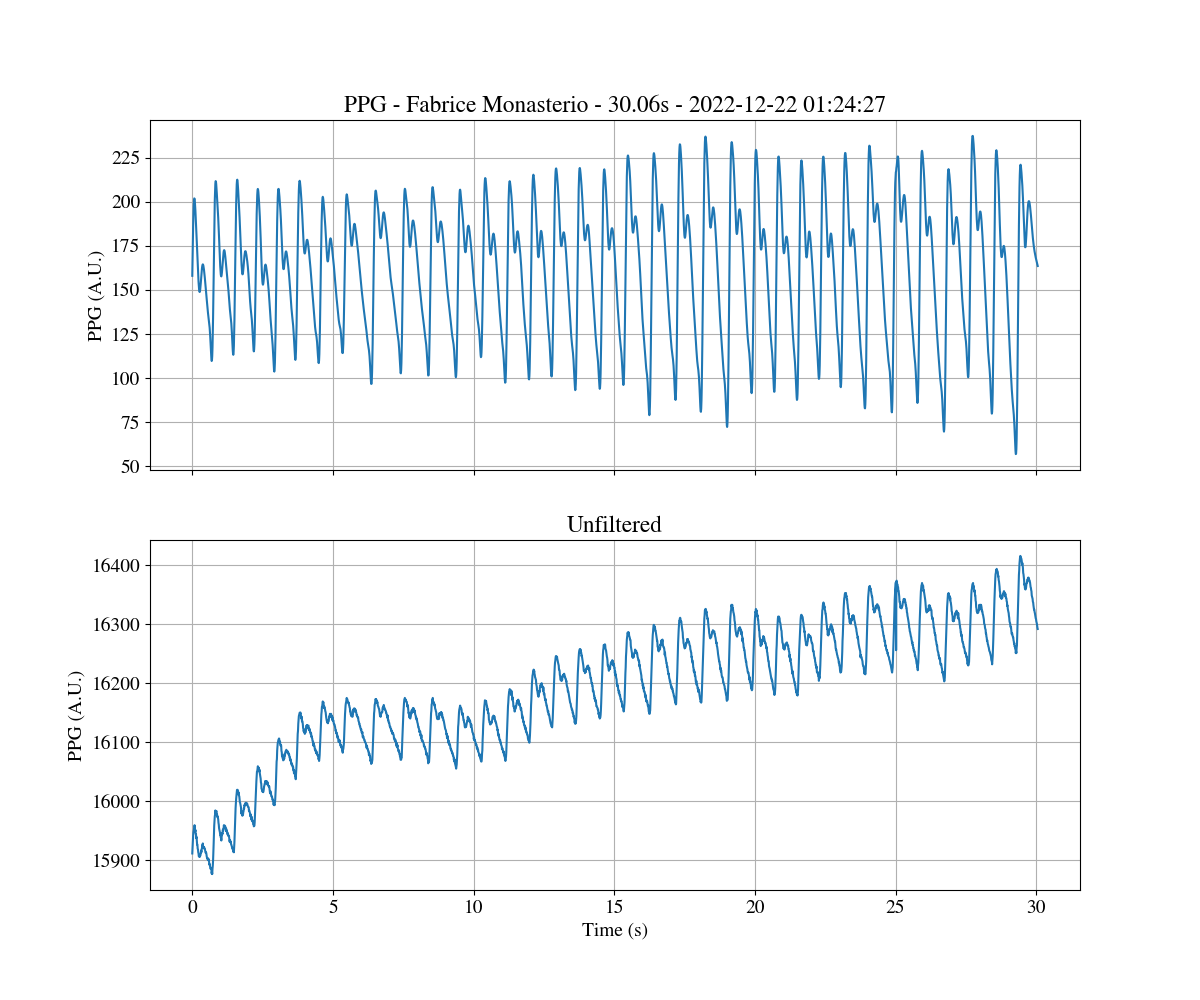

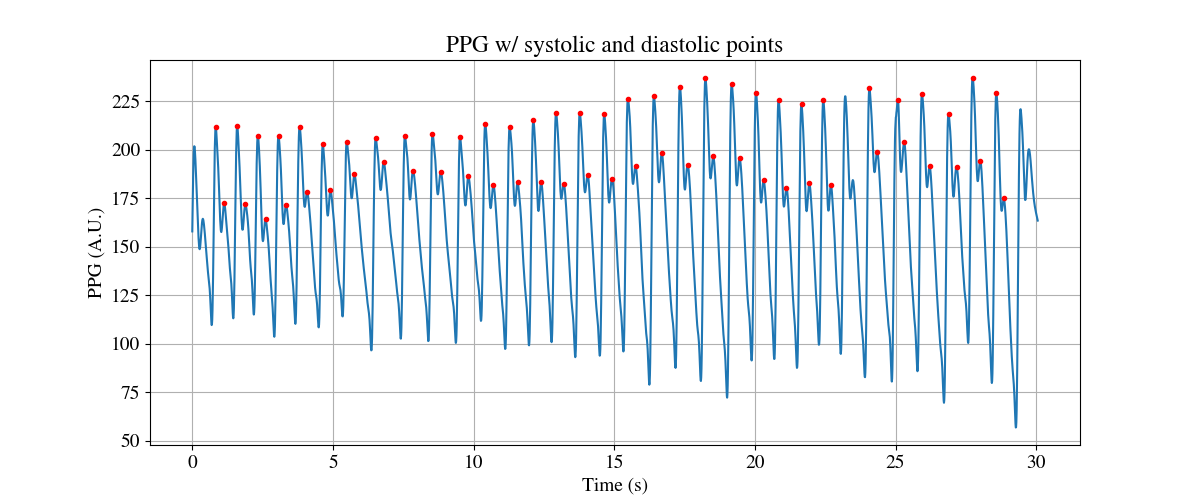

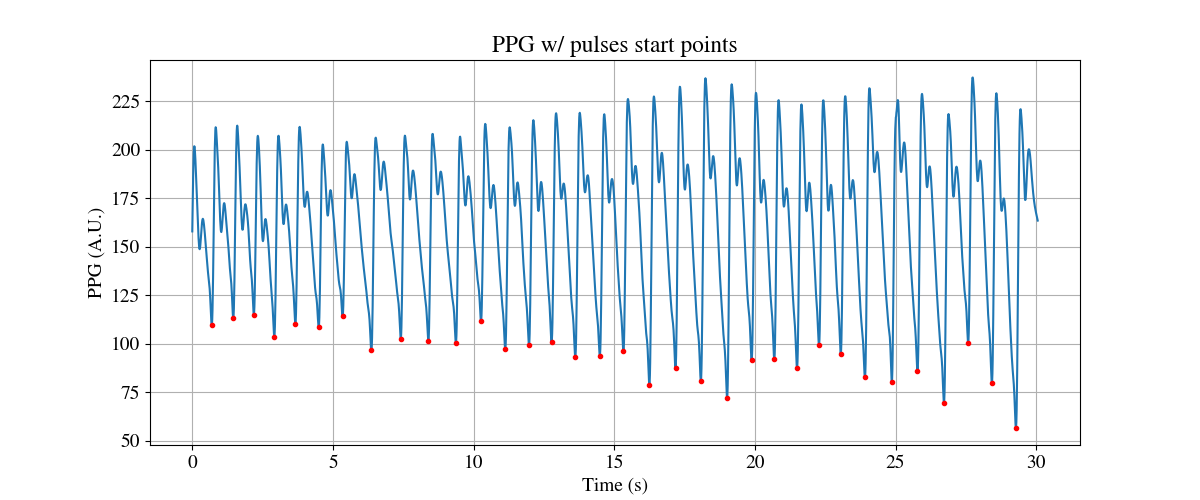

In [10]:
def main():
    # Sensor instance
    sensor = MAX30102()
    if not (sensor.check_part_id()):
        # Check that the targeted sensor is compatible
        print("I2C device ID not corresponding to MAX30102 or MAX30105.", file = sys.stderr)
    else:
        print("Sensor connected and recognized.") #, file = sys.stderr)

    sensor.setup_sensor(led_mode = 2,
                        adc_range = 16384,
                        sample_rate = 3200,
                        led_power = 128,
                        sample_avg = 4)

    time.sleep(0.25)

    print(f'Sensor temperature: {sensor.read_temperature()} °C') # , file = sys.stderr)
    
    subject = ask_user_info()
    # Default for quick testing
    # subject = SUBJECT(name = 'Fabrice Monasterio', heigth = 1.8, age = 22)
    # subject = SUBJECT(name = 'Fabio Motetta', heigth = 1.85, age = 22)
    clear_output(wait = True)
    subject.print_info()
    
    _ = input('Press enter to start the measurement')

    # Measure until valid
    while True:
        signal, fs = measure(sensor)

        ppg = PPG(
                  signal = signal,
                  fs = fs,
                  subject = subject,
                  date = datetime.now().isoformat(sep=' ', timespec = 'seconds'),
                  silent = True,
        )
        # If the measure is good break from the while
        if check_measure(ppg = ppg, subject = subject):
            # Shutdown PPG sensor
            del sensor
            save_measurement(ppg = ppg, subject = subject)
            break
        else:
            # Waiting for https://github.com/matplotlib/ipympl/issues/290 to be
            # fixed to enable plotting while waiting for the input
            # ppg.plot('signal')
            print('Re-insert your finger and press enter to try again, otherwise anything else to stop')
            if input() != '':
                clear_output(wait = False)
                return None, None
            else:
                clear_output(wait = True)

    check_health_status(ppg = ppg, subject = subject)

    ppg.print_indices_data()
    ppg.print_discarded_pulses()
    print('\n')
    ppg.plot('signal')
    ppg.plot('pulses')
    ppg.plot('peaks')
    
    return ppg, subject

if platform.machine() == 'aarch64':
    ppg, subject = main()

# subject.__dict__
# ppg.__dict__
# del sensor

# Access saved data

### Picke files

Mean    STD
Index                  
VA        10.600      -
SI         6.196      -
SDPTG_AI  -1.272   0.03
RI        71.595  3.055
dt         0.291    0.0
BPM       70.000      -

Unfiltered pulses: 35
Filtered pulses: 35
Trashed pulses: 0


Correct measure
Healthy subject


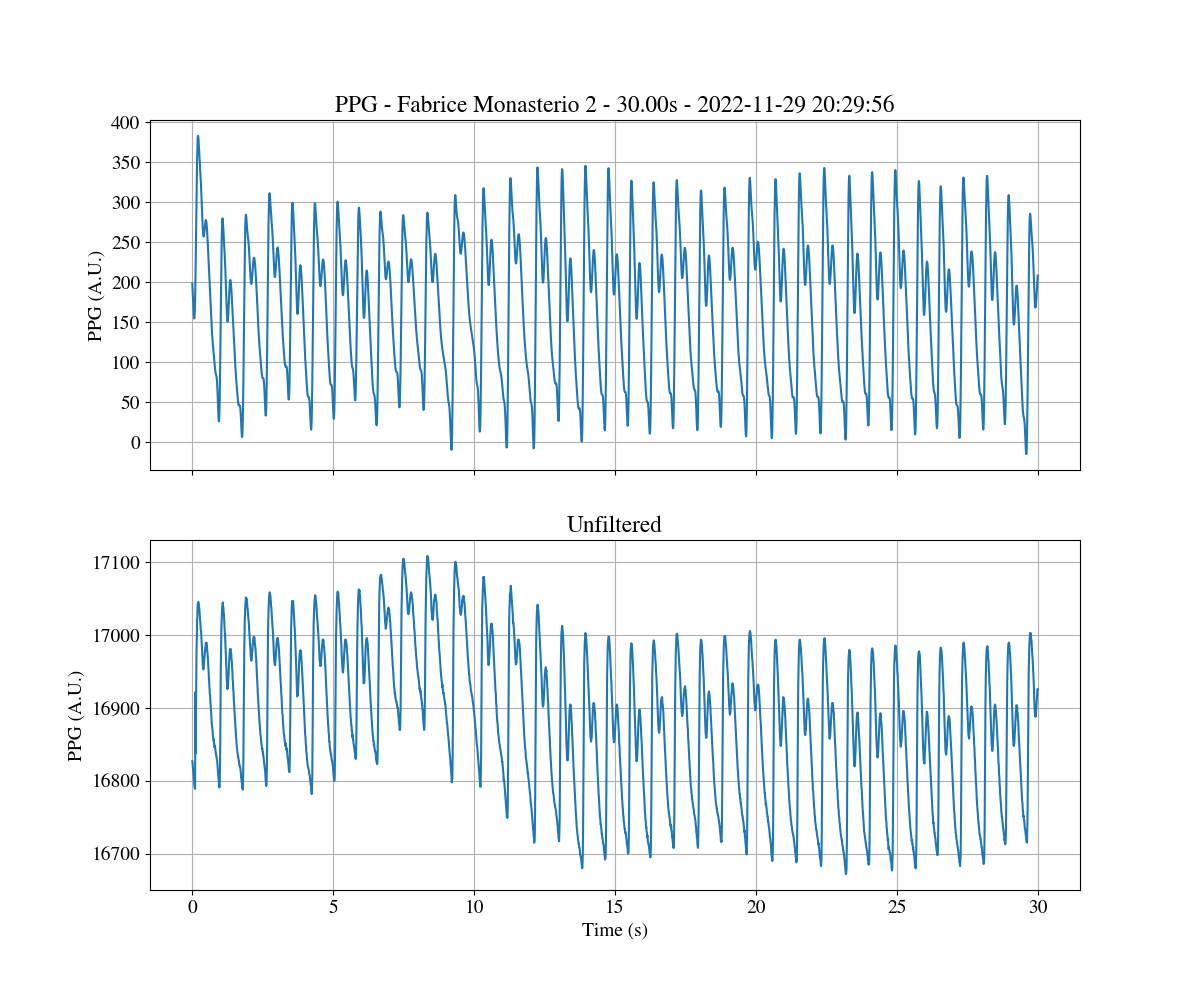

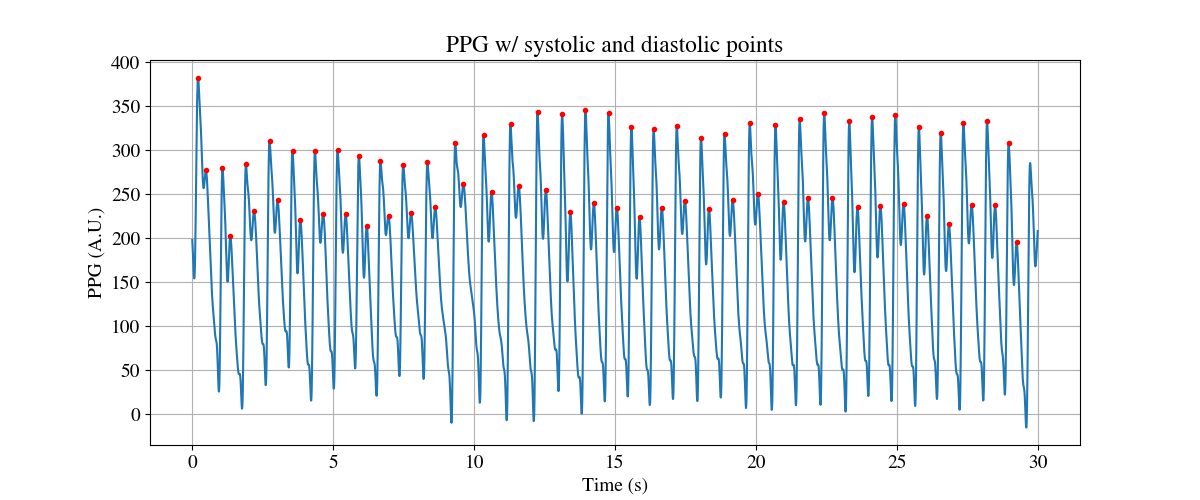

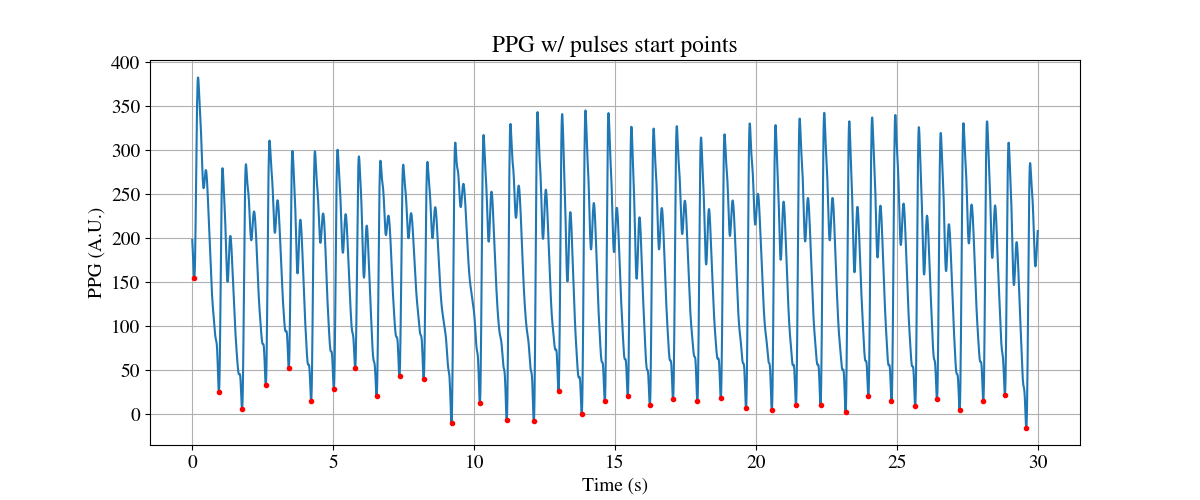

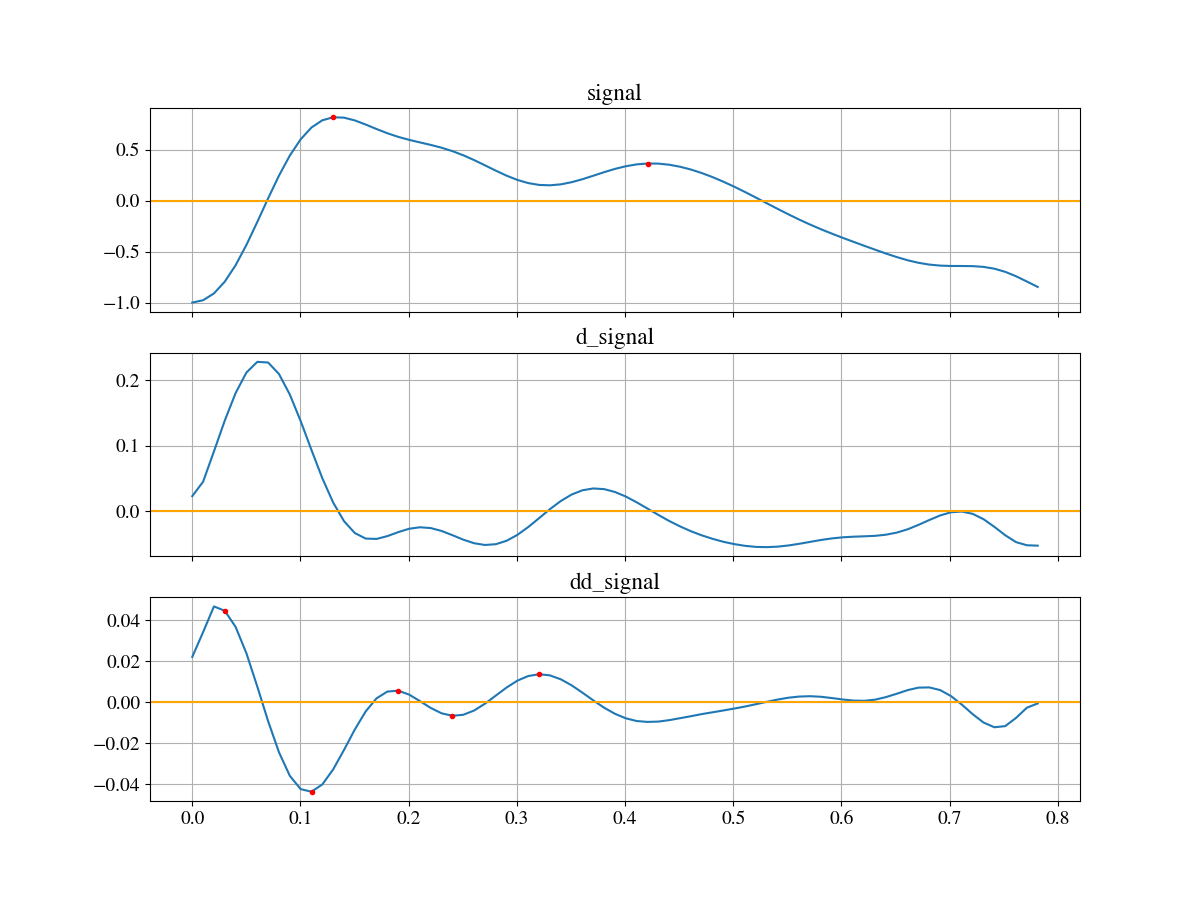

In [11]:
with open('Data/Measurements/ppg-fabrice-monasterio-2-180-2022-11-29-20:29:56.pickle', 'rb') as f:
    ppg_import, subject_import = pickle.load(f)

# subject_import.__dict__
# ppg_import.__dict__

# If the PPG or PULSE class are modified and you want to test the new version,
# extract the raw signal and create a new PPG object
ppg = PPG(
          signal = ppg_import.signal_unfilt,
          flipped = True,
          fs = ppg_import.fs,
          subject = subject_import,
          date = ppg_import.date,
)

PLT_FIGSIZE = (12, 3)
ppg.pulses[5].plot('signal')
PLT_FIGSIZE = PLT_FIGSIZE_O

# VASCOVID

Mean     STD
Index                   
VA        14.400       -
SI         8.414       -
SDPTG_AI  -1.183   0.254
RI        84.292  12.507
dt         0.214   0.044
BPM       66.000       -

Unfiltered pulses: 195
Filtered pulses: 29
Trashed pulses: 166


Healthy subject


Incorrect measure: Standard deviations too big


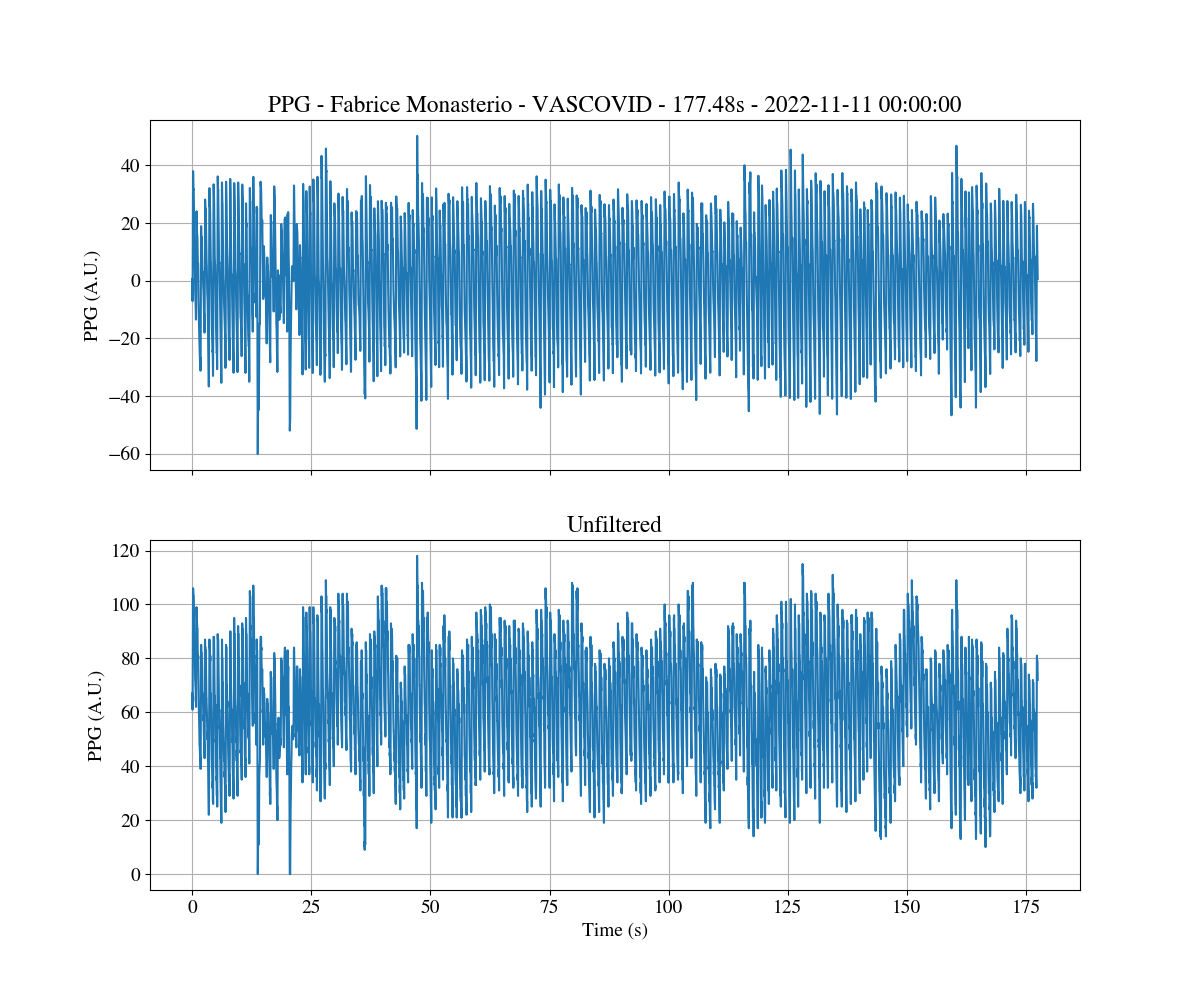

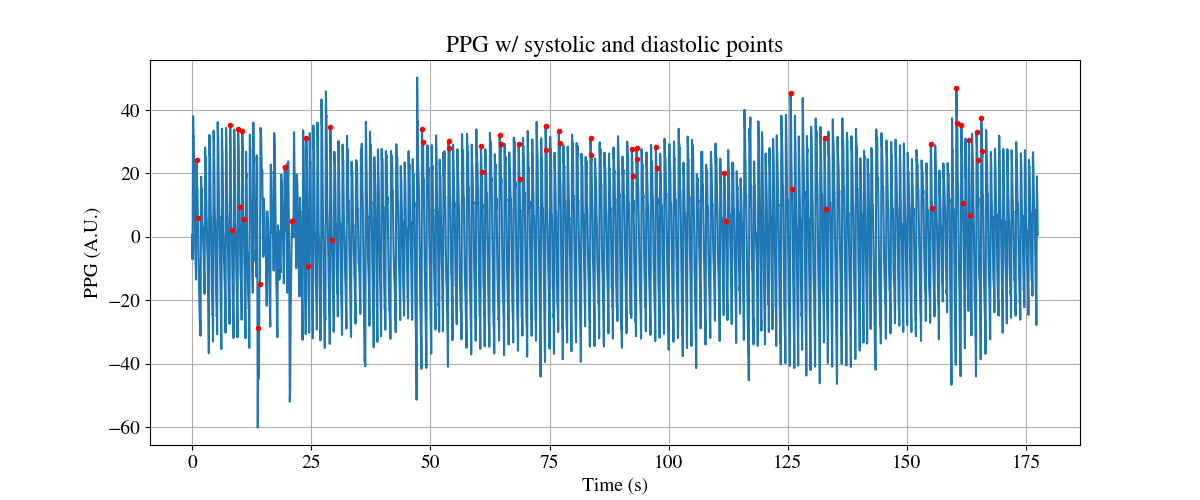

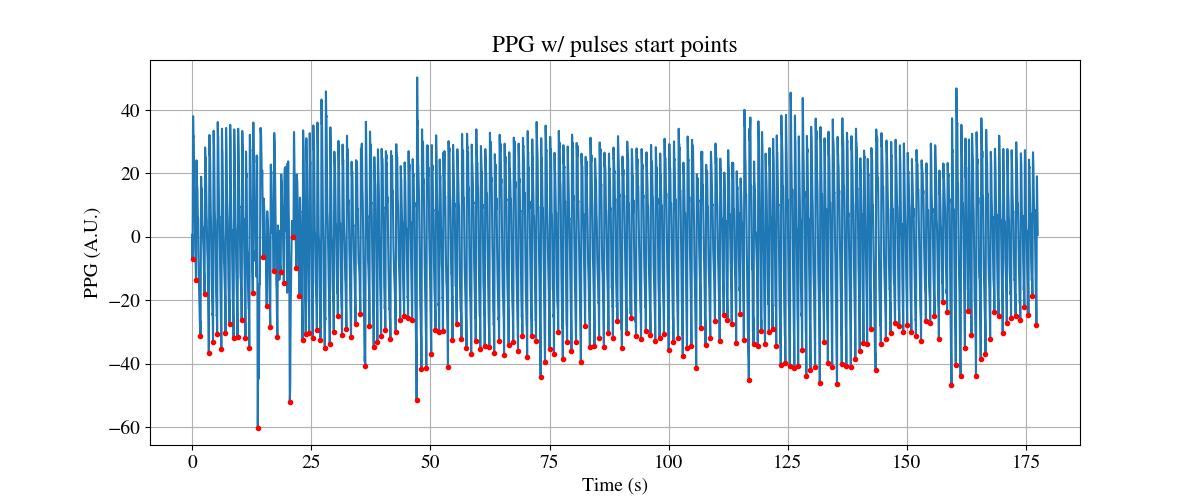

In [12]:
ppg_vascovid_fabrice = PPG(
            signal = import_txt('Data/VASCOVID/ppg-vascovid-fabrice.txt'),
            fs = 55.6,
            subject = SUBJECT(name = 'Fabrice Monasterio', heigth = 1.8, age = 22),
            info = 'VASCOVID',
            date = datetime(2022, 11, 11),
            flipped = True,
            )

Mean    STD
Index                  
VA        20.100      -
SI         6.123      -
SDPTG_AI  -1.054  0.217
RI        47.292  6.871
dt         0.302  0.017
BPM       77.000      -

Unfiltered pulses: 340
Filtered pulses: 21
Trashed pulses: 319




Incorrect measure: Standard deviations too big
Unhealthy subject


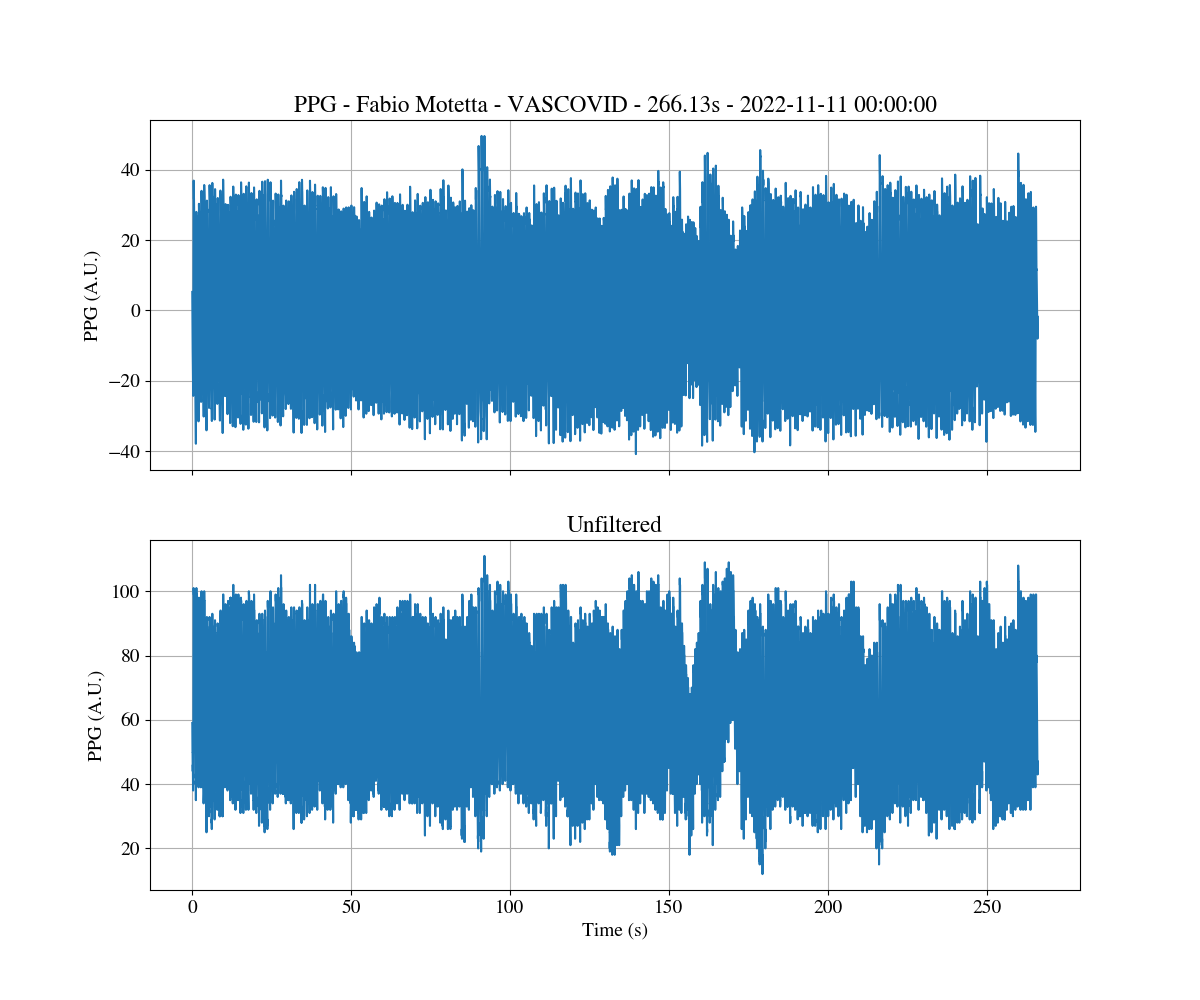

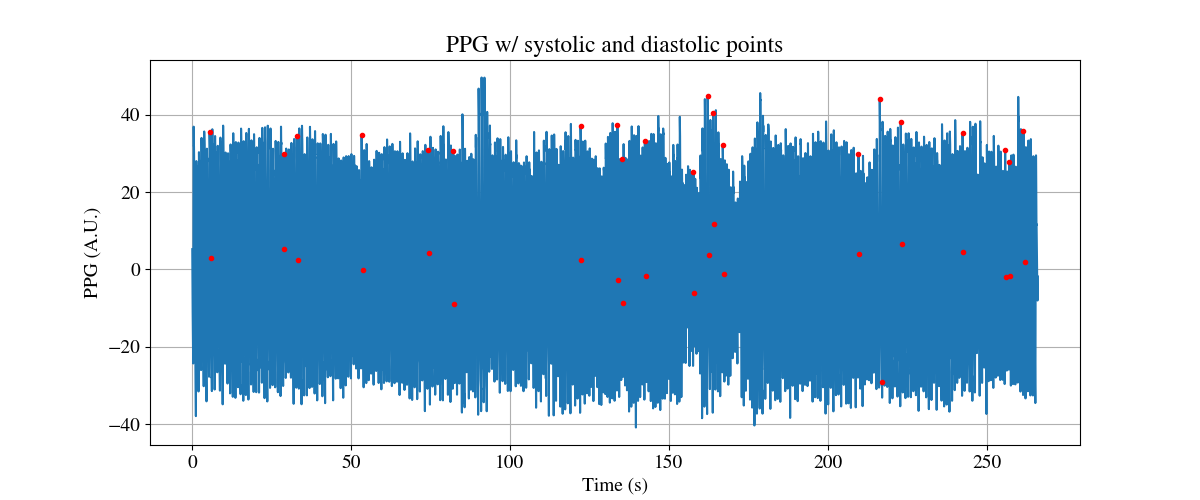

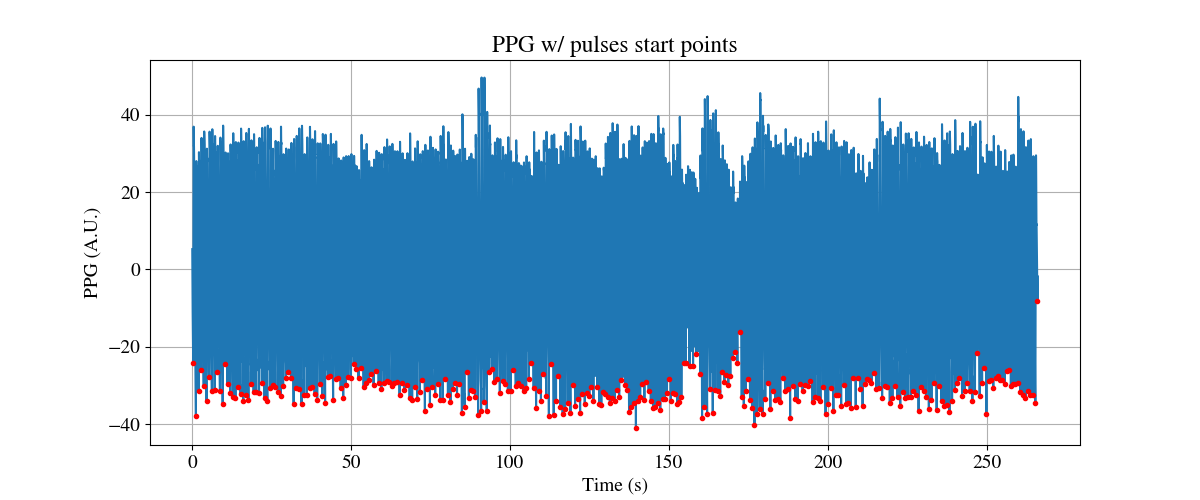

In [13]:
ppg_vascovid_fabio = PPG(
            signal = import_txt('Data/VASCOVID/ppg-vascovid-fabio.txt'),
            fs = 55.6,
            subject = SUBJECT(name = 'Fabio Motetta', heigth = 1.85, age = 21),
            info = 'VASCOVID',
            date = datetime(2022, 11, 11),
            flipped = True,
            )

# Plots for Paper

In [14]:
with open('Data/Measurements/ppg-fabrice-monasterio-2-180-2022-11-29-20:29:56.pickle', 'rb') as f:
    ppg, subject = pickle.load(f)
    
subject.name = 'Fabrice Monasterio'
subject.__dict__
# ppg.__dict__


ppg = PPG(
          signal = ppg.signal_unfilt[100*14:100*25],
          fs = ppg.fs,
          subject = subject,
          date = ppg.date,
          flipped = True,
          silent = True,
)

{'name': 'Fabrice Monasterio', 'heigth': 1.8, 'age': 22.0, 'risk': False}

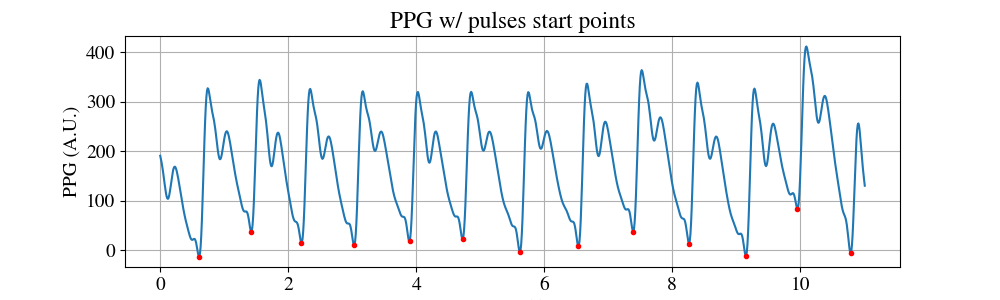

In [15]:
PLT_FIGSIZE = (10, 3)
ppg.plot('peaks')
PLT_FIGSIZE = PLT_FIGSIZE_O
plt.savefig('PPGPeaks.svg')

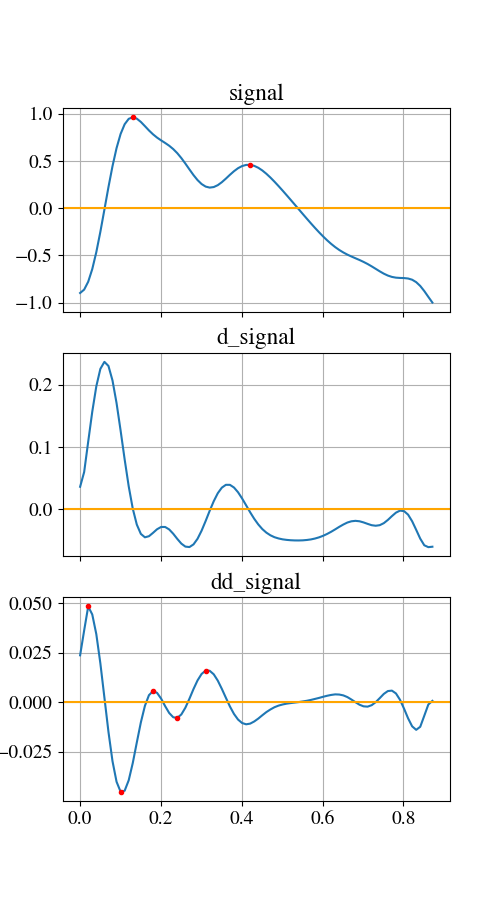

In [16]:
# First change the figsize argument in the class function
PLT_FIGSIZE = (5, 3)
ppg.pulses[5].plot('signal')
PLT_FIGSIZE = PLT_FIGSIZE_O
plt.savefig('PulsePlot.svg')

# Measurements Export

In [17]:
import os
import pandas as pd
measurements = []
directory = 'Data/Measurements/'
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    if os.path.isfile(file) and file.endswith('.pickle'):
        with open(file, 'rb') as f:
            ppg, subject = pickle.load(f)
            m = {'Name': subject.name,
                 'Age': subject.age,
                 'VA': ppg.VA,
                 'SDPTG_AI': ppg.SDPTG_AI,
                 'SI': ppg.SI,
                 'RI': ppg.RI,
                 'dt': np.mean(ppg.indices['dt']),
                 'num_pulses': np.size(ppg.pulses),
                 'std(SDPTG_AI)': np.std(ppg.indices['SDPTG_AI']),
                 'std(RI)': np.std(ppg.indices['RI']),
                 'std(dt)': np.std(ppg.indices['dt']),
                 'date': ppg.date,
                }
            measurements.append(m)
            
df = pd.DataFrame(data = measurements)
df = df.set_index('Name')
df
df.to_excel(directory + 'measurements.xlsx')

Age         VA  SDPTG_AI        SI         RI  \
Name                                                                   
Fabrice Monasterio    22.0  21.225596 -1.026811  6.562857  71.810201   
Fabio Motetta         21.0   9.322373 -1.300585  7.109309  75.979444   
Fabrice Monasterio    22.0  16.226998 -1.141779  6.271426  69.938264   
Fabio Motetta 4       21.0   1.782509 -1.474002  6.916756  82.527876   
Fabrice Monasterio    22.0  17.817552 -1.105196  6.320350  79.951237   
Fabio Motetta 5       21.0   7.669668 -1.338598  6.977619  78.104063   
Fabrice Monasterio 2  22.0  10.572171 -1.271840  6.196011  71.595264   
Fabrice Monasterio    22.0  17.414405 -1.114469  6.260531  64.318892   
Fabio Motetta 2       21.0   2.723128 -1.452368  6.579492  72.040569   
Fabio Motetta 3       21.0  12.026999 -1.238379  6.940873  91.917368   
Fabrice Monasterio    22.0  20.053190 -1.053777  6.634417  70.832121   

                            dt  num_pulses  std(SDPTG_AI)   std(RI)  \
Name                                                                  
Fabrice Monasterio    0.274271          32       0.038688  4.116527   
Fabio Motetta         0.260222          31       0.049789  3.703333   
Fabrice Monasterio    0.287016          33       0.027611  2.190207   
Fabio Motetta 4       0.267466          32       0.042351  2.277933   
Fabrice Monasterio    0.284794          31       0.033785  2.743795   
Fabio Motetta 5       0.265133          22       0.024935  1.787289   
Fabrice Monasterio 2  0.290510          35       0.030321  3.054911   
Fabrice Monasterio    0.287516          35       0.054312  1.364655   
Fabio Motetta 2       0.281177          32       0.035702  1.806125   
Fabio Motetta 3       0.266537          30       0.038785  2.290367   
Fabrice Monasterio    0.271312          27       0.057074  2.889851   

                           std(dt)                 date  
Name                                                     
Fabrice Monasterio    7.391935e-03  2022-12-22 01:24:27  
Fabio Motetta         5.551115e-17  2022-11-26 00:09:27  
Fabrice Monasterio    4.936963e-03  2022-12-22 01:11:42  
Fabio Motetta 4       4.636226e-03  2022-11-26 15:56:29  
Fabrice Monasterio    4.986303e-03  2022-11-29 20:28:26  
Fabio Motetta 5       5.001336e-03  2022-11-27 20:57:16  
Fabrice Monasterio 2  5.551115e-17  2022-11-29 20:29:56  
Fabrice Monasterio    5.035522e-03  2022-12-22 01:06:22  
Fabio Motetta 2       0.000000e+00  2022-11-26 15:48:49  
Fabio Motetta 3       4.937627e-03  2022-11-26 15:51:22  
Fabrice Monasterio    0.000000e+00  2022-12-22 01:17:04